# Notebook 3: Implementación de Estrategia Momentum

## Objetivo
Implementación de selección mensual de activos usando metodología MSCI Momentum adaptada. 
**OPTIMIZADO:** Usa retornos pre-calculados del Notebook 2 (R_12, R_6), evitando loops de ventanas.

## Metodología MSCI Momentum

Para cada fecha de rebalanceo:
1. **Filtrar elegibles:** Usar `eligibility_mask` para obtener activos elegibles
2. **Obtener retornos pre-calculados:** R_12 y R_6 del Notebook 2
3. **Calcular Z-scores:** Normalización dentro del universo elegible
4. **Score compuesto:** Media de Z_12 y Z_6
5. **Seleccionar top 20:** Activos con mayor score

## Índice
1. [Configuración e Imports](#configuracion)
2. [Carga de Datos](#carga)
3. [Funciones de Cálculo Vectorizadas](#funciones)
4. [Loop Principal de Selección](#loop)
5. [Visualizaciones y Validaciones](#visualizaciones)
6. [Guardado de Resultados](#guardado)

---

## 1. Configuración e Imports {#configuracion}

In [ ]:
"""
Notebook 3: Implementación de Estrategia Momentum

Genera señales de selección mensual usando:
- Retornos pre-calculados (R_12, R_6) del Notebook 2
- Z-scores normalizados por universo elegible
- Selección de top 20 activos por score compuesto

OUTPUT: CSV con 20 tickers seleccionados por fecha de rebalanceo
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
DATA_PROCESSED_DIR = '../datos/processed'
N_ACTIVOS_SELECCION = 20

# Estilo de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*70)
print("NOTEBOOK 3: IMPLEMENTACIÓN DE ESTRATEGIA MOMENTUM")
print("="*70)

NOTEBOOK 3: IMPLEMENTACIÓN DE ESTRATEGIA MOMENTUM


## 2. Carga de Datos {#carga}

Carga de retornos pre-calculados y máscara de elegibilidad del Notebook 2.

In [2]:
print("\n" + "="*70)
print("CARGANDO DATOS PROCESADOS")
print("="*70)

# Cargar retornos pre-calculados
returns_12m_rebal = pd.read_parquet(f'{DATA_PROCESSED_DIR}/returns_12m_rebal.parquet')
returns_6m_rebal = pd.read_parquet(f'{DATA_PROCESSED_DIR}/returns_6m_rebal.parquet')
eligibility_mask = pd.read_parquet(f'{DATA_PROCESSED_DIR}/eligibility_mask.parquet')
rebalance_dates = pd.read_csv(f'{DATA_PROCESSED_DIR}/rebalance_dates.csv', 
                               parse_dates=['date'])['date']

print(f"Retornos 12M: {returns_12m_rebal.shape}")
print(f"Retornos 6M: {returns_6m_rebal.shape}")
print(f"Eligibility mask: {eligibility_mask.shape}")
print(f"Fechas de rebalanceo: {len(rebalance_dates)}")

# Verificación de formato WIDE
assert returns_12m_rebal.shape == eligibility_mask.shape, "Shapes inconsistentes"
print("\n✓ Datos cargados correctamente")


CARGANDO DATOS PROCESADOS
Retornos 12M: (133, 845)
Retornos 6M: (133, 845)
Eligibility mask: (133, 845)
Fechas de rebalanceo: 133

✓ Datos cargados correctamente


## 3. Funciones de Cálculo Vectorizadas {#funciones}

Funciones para calcular z-scores y scores compuestos de momentum.

In [3]:
def calculate_z_scores(returns: pd.Series) -> pd.Series:
    """
    Calcula z-scores de retornos.
    
    Z-score = (r_i - mu) / sigma
    
    Parameters
    ----------
    returns : pd.Series
        Retornos de activos elegibles
    
    Returns
    -------
    pd.Series
        Z-scores normalizados
    """
    # Eliminar NaN antes de calcular
    returns_clean = returns.dropna()
    
    if len(returns_clean) < 2:
        # No hay suficientes activos para calcular z-scores
        return pd.Series(dtype=float)
    
    mu = returns_clean.mean()
    sigma = returns_clean.std()
    
    if sigma == 0:
        # Sin varianza, retornar 0s
        return pd.Series(0, index=returns_clean.index)
    
    z_scores = (returns_clean - mu) / sigma
    return z_scores


def calculate_momentum_score(R_12: pd.Series, R_6: pd.Series) -> pd.Series:
    """
    Calcula score compuesto de momentum.
    
    Score = (Z_12 + Z_6) / 2
    
    Parameters
    ----------
    R_12 : pd.Series
        Retornos acumulados 12 meses
    R_6 : pd.Series
        Retornos acumulados 6 meses
    
    Returns
    -------
    pd.Series
        Scores compuestos
    """
    # Calcular z-scores
    Z_12 = calculate_z_scores(R_12)
    Z_6 = calculate_z_scores(R_6)
    
    # Alinear índices (solo activos con ambos z-scores)
    common_idx = Z_12.index.intersection(Z_6.index)
    
    if len(common_idx) == 0:
        return pd.Series(dtype=float)
    
    # Score compuesto
    score = (Z_12.loc[common_idx] + Z_6.loc[common_idx]) / 2
    return score


def select_top_n(scores: pd.Series, n: int = 20) -> list:
    """
    Selecciona los n activos con mayor score.
    
    Parameters
    ----------
    scores : pd.Series
        Scores de momentum
    n : int
        Número de activos a seleccionar
    
    Returns
    -------
    list
        Tickers seleccionados (ordenados por score descendente)
    """
    # Eliminar NaN
    scores_clean = scores.dropna()
    
    # Ordenar descendente y tomar top n
    top_n = scores_clean.nlargest(n)
    
    return top_n.index.tolist()

## 4. Loop Principal de Selección {#loop}

Iteración sobre fechas de rebalanceo para seleccionar top 20 activos.

In [4]:
print("\n" + "="*70)
print("EJECUTANDO SELECCIÓN MENSUAL")
print("="*70)

# Inicializar resultados
selecciones = []
estadisticas = []

# Loop sobre fechas de rebalanceo
for i, fecha in enumerate(rebalance_dates):
    
    # 1. Obtener activos elegibles este mes
    elegibles = eligibility_mask.loc[fecha]
    tickers_elegibles = elegibles[elegibles].index
    n_elegibles = len(tickers_elegibles)
    
    # 2. Obtener retornos pre-calculados (solo elegibles)
    R_12 = returns_12m_rebal.loc[fecha, tickers_elegibles]
    R_6 = returns_6m_rebal.loc[fecha, tickers_elegibles]
    
    # 3. Calcular scores
    scores = calculate_momentum_score(R_12, R_6)
    
    # 4. Seleccionar top 20
    top_20 = select_top_n(scores, n=N_ACTIVOS_SELECCION)
    
    # 5. Validación
    if len(top_20) < N_ACTIVOS_SELECCION:
        print(f"ADVERTENCIA: Fecha {fecha}, solo {len(top_20)} activos seleccionados")
    
    # 6. Guardar selección
    seleccion_dict = {'fecha': fecha}
    for j, ticker in enumerate(top_20):
        seleccion_dict[f'ticker_{j+1}'] = ticker
    selecciones.append(seleccion_dict)
    
    # 7. Guardar estadísticas
    estadisticas.append({
        'fecha': fecha,
        'n_elegibles': n_elegibles,
        'n_seleccionados': len(top_20),
        'score_min': scores.min() if len(scores) > 0 else np.nan,
        'score_max': scores.max() if len(scores) > 0 else np.nan,
        'score_mean': scores.mean() if len(scores) > 0 else np.nan
    })
    
    # Progress cada 20 fechas
    if (i + 1) % 20 == 0:
        print(f"  Procesadas {i+1}/{len(rebalance_dates)} fechas")

print(f"\n✓ Selección completada: {len(selecciones)} fechas procesadas")

# Convertir a DataFrames
df_selecciones = pd.DataFrame(selecciones)
df_estadisticas = pd.DataFrame(estadisticas)


EJECUTANDO SELECCIÓN MENSUAL
  Procesadas 20/133 fechas
  Procesadas 40/133 fechas
  Procesadas 60/133 fechas
  Procesadas 80/133 fechas
  Procesadas 100/133 fechas
  Procesadas 120/133 fechas

✓ Selección completada: 133 fechas procesadas


## 5. Visualizaciones y Validaciones {#visualizaciones}

Análisis de evolución temporal y validaciones de integridad.


VISUALIZACIONES Y VALIDACIONES


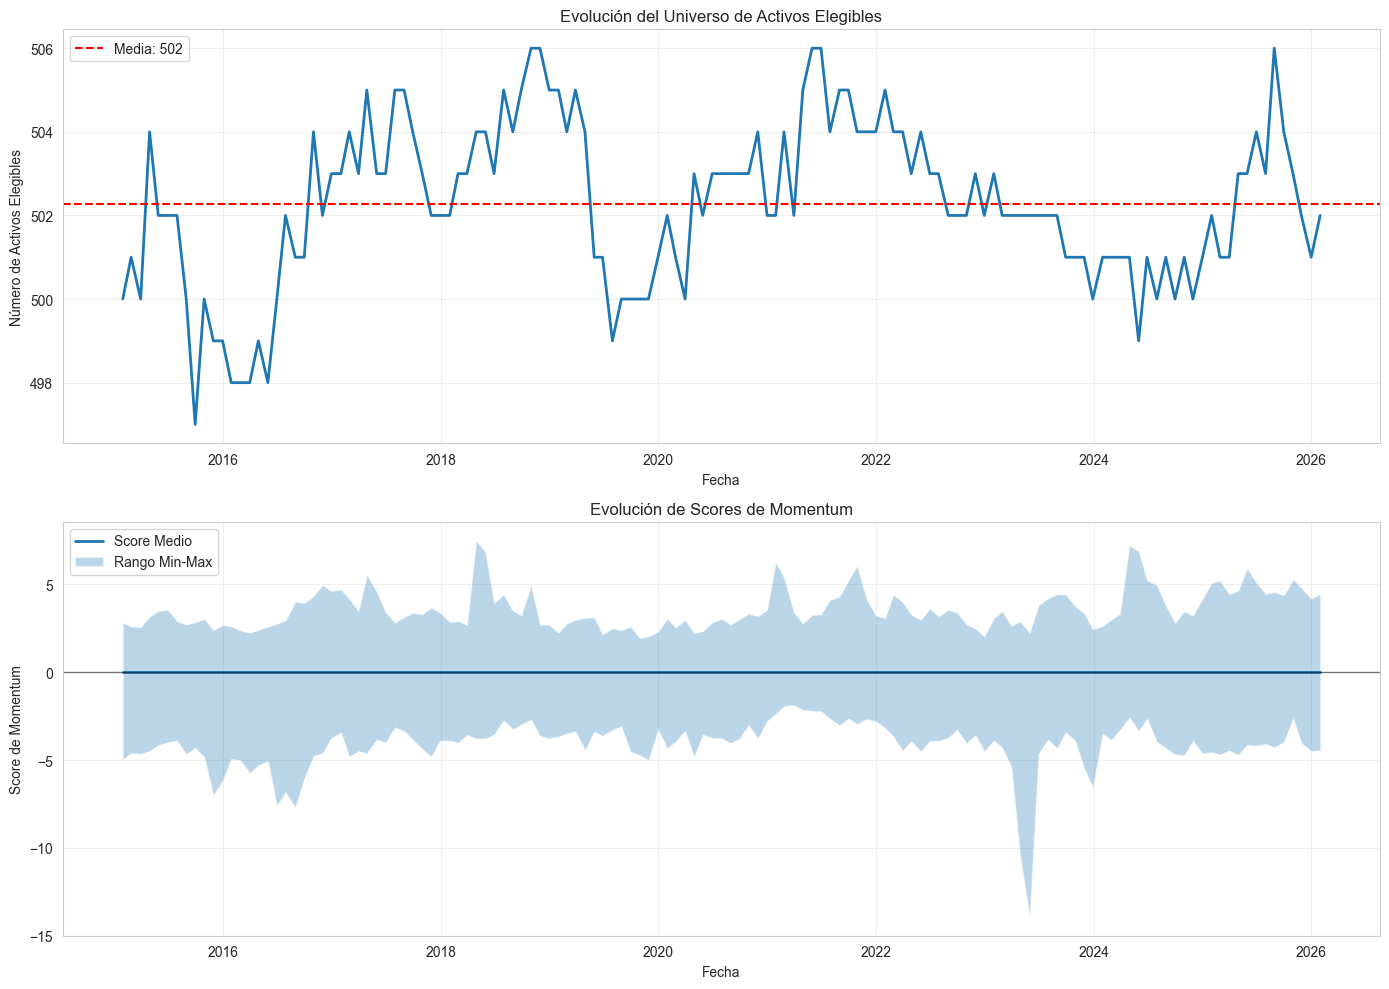


Análisis de recurrencia de tickers:
  Tickers únicos seleccionados: 413
  Top 10 más frecuentes:
NVDA    76
NFLX    43
AMD     42
MU      33
AVGO    32
AMAT    30
NRG     29
AMZN    28
LRCX    27
RCL     25
Name: count, dtype: int64

Validaciones:
  Todas las filas tienen 20 activos: True
  Sin duplicados en filas: True


In [5]:
print("\n" + "="*70)
print("VISUALIZACIONES Y VALIDACIONES")
print("="*70)

# Gráfico 1: Evolución de activos elegibles
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(df_estadisticas['fecha'], df_estadisticas['n_elegibles'], linewidth=2)
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Número de Activos Elegibles')
axes[0].set_title('Evolución del Universo de Activos Elegibles')
axes[0].grid(alpha=0.3)
axes[0].axhline(df_estadisticas['n_elegibles'].mean(), color='red', 
                linestyle='--', label=f"Media: {df_estadisticas['n_elegibles'].mean():.0f}")
axes[0].legend()

# Gráfico 2: Distribución de scores
axes[1].plot(df_estadisticas['fecha'], df_estadisticas['score_mean'], 
             label='Score Medio', linewidth=2)
axes[1].fill_between(df_estadisticas['fecha'], 
                      df_estadisticas['score_min'], 
                      df_estadisticas['score_max'], 
                      alpha=0.3, label='Rango Min-Max')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Score de Momentum')
axes[1].set_title('Evolución de Scores de Momentum')
axes[1].grid(alpha=0.3)
axes[1].legend()
axes[1].axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# Análisis de recurrencia de tickers
print("\nAnálisis de recurrencia de tickers:")
all_selected_tickers = []
for col in df_selecciones.columns:
    if col.startswith('ticker_'):
        all_selected_tickers.extend(df_selecciones[col].dropna().tolist())

ticker_counts = pd.Series(all_selected_tickers).value_counts()
print(f"  Tickers únicos seleccionados: {len(ticker_counts)}")
print(f"  Top 10 más frecuentes:")
print(ticker_counts.head(10))

# Validaciones
print("\nValidaciones:")
print(f"  Todas las filas tienen 20 activos: {(df_selecciones.iloc[:, 1:].notna().sum(axis=1) == N_ACTIVOS_SELECCION).all()}")
print(f"  Sin duplicados en filas: {df_selecciones.iloc[:, 1:].apply(lambda x: x.nunique() == x.notna().sum(), axis=1).all()}")

## 6. Guardado de Resultados {#guardado}

Generación del CSV final con selecciones mensuales.

In [6]:
print("\n" + "="*70)
print("GUARDANDO SELECCIONES")
print("="*70)

# Guardar CSV
output_path = f'{DATA_PROCESSED_DIR}/selecciones_mensuales.csv'
df_selecciones.to_csv(output_path, index=False)

print(f"✓ Archivo guardado: {output_path}")
print(f"  Dimensiones: {df_selecciones.shape}")
print(f"  Columnas: fecha + {N_ACTIVOS_SELECCION} tickers")

# Mostrar primeras y últimas selecciones
print("\nPrimeras 3 selecciones:")
print(df_selecciones.head(3))

print("\nÚltimas 3 selecciones:")
print(df_selecciones.tail(3))

print("\n" + "="*70)
print("NOTEBOOK 3 COMPLETADO")
print("="*70)
print("\nPróximo paso: Notebook 4 - Motor de Backtesting")


GUARDANDO SELECCIONES
✓ Archivo guardado: ../datos/processed/selecciones_mensuales.csv
  Dimensiones: (133, 21)
  Columnas: fecha + 20 tickers

Primeras 3 selecciones:
       fecha    ticker_1 ticker_2 ticker_3 ticker_4      ticker_5    ticker_6  \
0 2015-01-30         LUV       EW     AVGO       EA           RCL        MNST   
1 2015-02-27         LUV       EA     MNST     AVGO  MNKKQ-202206          KR   
2 2015-03-31  HSP-201509     AVGO     MNST       EA   ANDV-201809  AGN-201503   

     ticker_7      ticker_8 ticker_9  ...    ticker_11 ticker_12    ticker_13  \
0  AGN-201503  MNKKQ-202206      DAL  ...         REGN        KR  SPLS-201709   
1          EW    AGN-201503     BBWI  ...  ANDV-201809       WHR  CELG-201911   
2         LUV          BBWI       EW  ...           KR      DLTR         AAPL   

  ticker_14    ticker_15     ticker_16    ticker_17 ticker_18 ticker_19  \
0       LOW  SIAL-201511    CFN-201503         VRTX       MAR      AMGN   
1       LOW          MAC       